Path to dataset files: /home/carl/.cache/kagglehub/datasets/gufukuro/movie-scripts-corpus/versions/1

Recherche du fichier de métadonnées principal...
-> Fichier candidat trouvé : movie_meta_data.csv | Colonnes : ['year']

SUCCÈS : Métadonnées chargées depuis year.


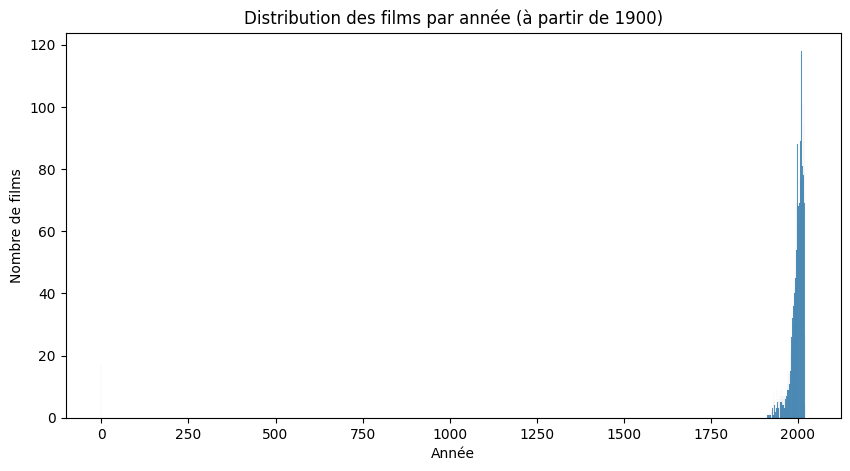

Dossier des scripts : /home/carl/.cache/kagglehub/datasets/gufukuro/movie-scripts-corpus/versions/1/screenplay_data/data/raw_text_lemmas/raw_text_lemmas
Chargement des textes (peut prendre du temps)...
Nombre final de films avec script et année : 2492


In [15]:
# --- Cellule 1 : Imports et Téléchargement ---
import kagglehub
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Téléchargement du dataset
path = kagglehub.dataset_download("gufukuro/movie-scripts-corpus")
print("Path to dataset files:", path)

# --- Cellule 2 : Chargement Intelligent des Métadonnées ---
# On cherche le fichier qui contient l'année ('Year' ou 'launch_year')
print("\nRecherche du fichier de métadonnées principal...")

metadata_dir = os.path.join(path, "movie_metadata")
all_csvs = glob.glob(os.path.join(metadata_dir, "*.csv"))
# On ajoute aussi la racine au cas où
all_csvs += glob.glob(os.path.join(path, "*.csv"))

df_meta = None
year_col = None

for csv_file in all_csvs:
    try:
        temp_df = pd.read_csv(csv_file)
        # Nettoyage des noms de colonnes
        temp_df.columns = [c.strip() for c in temp_df.columns]
        
        # Vérification des colonnes candidates pour l'année
        candidates = [c for c in temp_df.columns if 'year' in c.lower() or 'date' in c.lower()]
        
        if candidates:
            # On vérifie si ce n'est pas juste un fichier d'awards (trop petit ou pas de titre)
            if len(temp_df) > 500: # Le fichier principal doit avoir > 2000 films
                print(f"-> Fichier candidat trouvé : {os.path.basename(csv_file)} | Colonnes : {candidates}")
                df_meta = temp_df
                year_col = candidates[0] # On prend la première colonne "année" trouvée
                break
    except Exception as e:
        print(f"Erreur lecture {csv_file}: {e}")

# --- Modify the range of years for the histogram ---
if df_meta is not None:
    print(f"\nSUCCÈS : Métadonnées chargées depuis {year_col}.")
    # Normalisation de la colonne année
    df_meta['release_year'] = pd.to_numeric(df_meta[year_col], errors='coerce')
    df_meta = df_meta.dropna(subset=['release_year'])
    df_meta['decade'] = (df_meta['release_year'] // 10) * 10

    # Determine the range of years for the histogram
    min_year = max(1900, int(df_meta['release_year'].min()))  # Ensure the minimum year is at least 1900
    max_year = int(df_meta['release_year'].max())
    bins = range(min_year, max_year + 10, 10)  # Adjust bins to cover the range of years

    # Affichage de la distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(df_meta['release_year'].astype(int), bins=bins, discrete=True)
    plt.title("Distribution des films par année (à partir de 1900)")
    plt.xlabel("Année")
    plt.ylabel("Nombre de films")
    plt.show()
else:
    raise ValueError("Impossible de trouver un fichier CSV contenant une colonne 'Year' ou 'Date'.")

# --- Cellule 3 : Liaison avec les Scripts ---
# D'après votre log, les scripts sont dans 'screenplay_data/data/raw_text_lemmas/raw_text_lemmas'
# Le nom du fichier script correspond souvent au titre ou à un ID dans les métadonnées.

script_path = None
# Recherche récursive du dossier 'raw_text_lemmas'
for root, dirs, files in os.walk(path):
    if 'raw_text_lemmas' in root and len(files) > 100:
        script_path = root
        break

print(f"Dossier des scripts : {script_path}")

def load_script_content(row):
    # Logique de matching : On essaie de trouver le fichier qui contient le titre
    # Attention : C'est une heuristique simple. Idéalement, il y a un ID.
    if not isinstance(row.get('title'), str): return None
    
    safe_title = row['title'].replace(':', '').replace('?', '').strip()
    # On cherche un fichier qui commence par ce titre
    try:
        # Pattern matching simple
        potential_files = glob.glob(os.path.join(script_path, f"*{safe_title}*.txt"))
        if potential_files:
            with open(potential_files[0], 'r', encoding='utf-8', errors='ignore') as f:
                return f.read()
    except:
        return None
    return None

# Pour tester, on applique sur un échantillon
print("Chargement des textes (peut prendre du temps)...")
# On ne charge que pour les films qui ont une année valide
df_meta['script_content'] = df_meta.apply(load_script_content, axis=1)

# Filtrer les films sans scripts
df_final = df_meta.dropna(subset=['script_content'])
print(f"Nombre final de films avec script et année : {len(df_final)}")

In [ ]:
# --- Cellule 1 : Préparation du NLP ---
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import string

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text) # Enlever ponctuation
    words = text.split()
    return [w for w in words if w not in stop_words and len(w) > 2]

# Note: Il faudra charger le contenu textuel des scripts ici.
# Supposons que vous ayez une liste de scripts ou une colonne 'script_content'
# df_meta['clean_tokens'] = df_meta['script_content'].apply(clean_text)

# --- Cellule 2 : Entraînement Diachronique (Par décennie) ---
# On crée un dictionnaire de modèles Word2Vec, un par décennie
models_by_decade = {}
decades = sorted(df_meta['decade'].dropna().unique())

for dec in decades:
    # Filtrer les scripts de cette décennie
    scripts_decade = df_meta[df_meta['decade'] == dec]['clean_tokens'].tolist()
    
    if len(scripts_decade) > 0:
        print(f"Entraînement du modèle pour la décennie {dec}...")
        # Paramètres inspirés de CES_IA____Graph_Mining.pdf (Skip-gram ou CBOW)
        # sg=1 pour Skip-gram, souvent meilleur pour les datasets sémantiques
        model = Word2Vec(sentences=scripts_decade, vector_size=100, window=5, min_count=5, workers=4, sg=1)
        models_by_decade[dec] = model

# --- Cellule 3 : Visualisation des biais (Stéréotypes) ---
# On regarde les mots les plus proches de termes cibles (ex: "woman", "man")
target_word = "woman" # Changez pour 'man', 'foreigner', etc.

results = []
for dec, model in models_by_decade.items():
    if target_word in model.wv:
        # Récupérer les 10 mots les plus similaires
        neighbors = model.wv.most_similar(target_word, topn=5)
        neighbors_words = [n[0] for n in neighbors]
        results.append({'decade': dec, 'associated_words': ", ".join(neighbors_words)})

df_results = pd.DataFrame(results)
print(f"Évolution sémantique du mot '{target_word}' :")
display(df_results)

In [ ]:
# --- Cellule 1 : Création de Graphes d'Interaction ---
import networkx as nx
import numpy as np

# Fonction hypothétique pour extraire les interactions d'un script
# (Nécessite de parser le format spécifique du script : NOM: Dialogue)
def build_interaction_graph(script_text):
    G = nx.Graph()
    # Logique simplifiée : Si deux personnages parlent dans la même scène, on ajoute un lien
    # ... (code de parsing à adapter selon le format brut des fichiers txt)
    return G

# --- Cellule 2 : Mesure de Centralité ---
# Nous allons calculer la "Degree Centrality" (popularité) moyenne par genre
# Supposons que nous avons extrait les genres des personnages (M/F)

stats_centrality = []

# Itération sur un sous-ensemble de films
for idx, row in df_meta.iterrows():
    # G = build_interaction_graph(row['script_content']) 
    
    # Exemple fictif pour l'illustration
    # centrality = nx.degree_centrality(G)
    
    # Stocker les résultats avec l'année
    # stats_centrality.append({'year': row['release_year'], 'avg_centrality_female': ...})
    pass

# Note : Cette partie demande un parsing robuste des fichiers .txt du dataset